Get all targets

In [1]:
from __future__ import print_function, division
import os
import cv2
import argparse
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


class Attributes:
    def __init__(self):
        self.batch_size = 32
        self.test_batch_size = 1000
        self.epochs = 100
        self.lr = 1.0
        self.step = 1
        self.gamma = 0.7
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 100

args = Attributes()
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
torch.manual_seed(args.seed)

In [2]:
df = pd.read_csv('data/imet-2020-fgvc7/train.csv')
N_CLASSES = 3474
targets = np.zeros([df.shape[0],3474])
labs = df.iloc[:,1].str.split().to_numpy()
for (i,ls) in enumerate(labs):
    for l in ls:
        targets[(i,int(l))] = 1
np.savetxt('data/targets.txt', targets, fmt='%d')

KeyboardInterrupt: 

In [8]:
# Alternative (load targets)
import numpy as np
targets = np.loadtxt('data/targets.txt', dtype=int)

Grouping (Kmeans)

In [3]:
# Kmeans grouping
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=200, random_state=0).fit(targets)
kmeans.labels_
np.savetxt('data/kmeans200.txt', kmeans.labels_, fmt='%d')
print("data/kmeans200 saved")

data/kmeans200 saved


Grouping (PCA)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(targets)
new_targets = pca.transform(targets)
np.savetxt('data/PCA50.txt', new_targets, fmt='%d')
print("data/PCA50 saved")

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [12]:
from sklearn.manifold import TSNE
output_embedded = TSNE(n_components=3).fit_transform(new_targets)

In [22]:
from sklearn.cluster import KMeans
kmeans_pca = KMeans(n_clusters=20, random_state=0).fit(output_embedded)

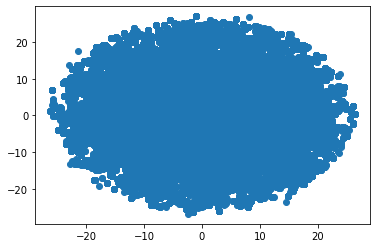

In [25]:
import matplotlib.pyplot as plt
plt.scatter(output_embedded[:,1], output_embedded[:,2])
np.savetxt('data/PCA50-TSNE3.txt', output_embedded, fmt='%d')
np.savetxt('data/PCA50-TSNE3-kmeans20.txt', kmeans_pca.labels_, fmt='%d')

Training set preprocessing

In [26]:
import pandas as pd
df = pd.read_csv('data/imet-2020-fgvc7/train.csv')

In [32]:
attribute_ids = df.iloc[:,1].str.split()
attribute_ids = pd.Series(np.concatenate(attribute_ids))
attribute_ids.value_counts()

3170    21784
781     21142
782     20672
785     20657
783     19881
        ...  
1398        1
2208        1
809         1
340         1
132         1
Length: 3471, dtype: int64

In [70]:
counts = attribute_ids.value_counts()
#labels = attribute_ids.value_counts().rename_axis('x').reset_index(name='f')['x'].iloc[0:10].tolist()
labels = []
for i in range(1,100):
    if counts[str(i)] > 50:
        labels.append(i)
#     print(i, counts[str(i)])
print(labels, len(labels))

[5, 10, 14, 15, 17, 22, 23, 26, 27, 29, 34, 42, 45, 51, 54, 59, 60, 65, 67, 71, 73, 78, 81, 83, 88, 90, 92, 95, 96] 29


In [71]:
country_labels = labels
ddf = pd.DataFrame([])
for index, row in df.iterrows():
    atts = row['attribute_ids'].split()
    for l in country_labels:
        if str(l) in atts:
            ddf = ddf.append(df.iloc[index,:])
            ddf.iloc[-1,:]['attribute_ids'] = l
            break
print(ddf.shape)

(24454, 2)


In [72]:
ddf.to_csv(r'data/imet-2020-fgvc7/train_29country.csv', index = False)

In [73]:
counts = attribute_ids.value_counts()
#labels = attribute_ids.value_counts().rename_axis('x').reset_index(name='f')['x'].iloc[0:10].tolist()
labels = []
for i in range(1,100):
    if counts[str(i)] > 100:
        labels.append(i)
#     print(i, counts[str(i)])
print(labels, len(labels))

[10, 14, 15, 17, 23, 26, 27, 29, 34, 42, 45, 51, 54, 60, 65, 73, 88, 90, 92, 96] 20


In [74]:
country_labels = labels
ddf = pd.DataFrame([])
for index, row in df.iterrows():
    atts = row['attribute_ids'].split()
    for l in country_labels:
        if str(l) in atts:
            ddf = ddf.append(df.iloc[index,:])
            ddf.iloc[-1,:]['attribute_ids'] = country_labels.index(l)
            break
print(ddf.shape)

(23871, 2)


In [75]:
ddf.to_csv(r'data/imet-2020-fgvc7/train_20country.csv', index = False)